### Eulerian autocovariance  filtered and demodulated signal
cf github/zcasparco/equinox_phd/llc4320/signal_filtering_store.ipynb for filtering and demodulation method

In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp


from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=6)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
#Load demodulated field
#ds = xr.open_zarr(ut.work_data_dir+'diags/SSV_low_mean1_autocov.zarr')
chunks_i, chunks_j = 1080//4, 1080//4
ds = xr.open_zarr(ut.work_data_dir+'diags/SSU_autocov_bis.zarr',chunks={'i':1080//4,'j':1080//4}
                 ).isel(i=slice(0,None,2),j=slice(0,None,2))
grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr',chunks={'i':1080//4,'j':1080//4}
                  )[['XC','YC','Depth']].isel(i=slice(0,None,4),j=slice(0,None,4))
#grd = grd.chunk({'i':100,'j':100})
#grd = grd.isel(i=slice(0,None,4),j=slice(0,None,4))
#ds = xr.merge([ds.isel(i=slice(0,None,2),j=slice(0,None,2)),grd.isel(i=slice(0,None,4),j=slice(0,None,4))])
ds

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/dataset.py:410: UserWarning: Specified Dask chunks (270, 270, 270, 270, 270, 270, 270, 270) would separate on disks chunk shape 25 for dimension j. This could degrade performance. Consider rechunking after loading instead.
  _check_chunks_compatibility(var, output_chunks, preferred_chunks)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/dataset.py:410: UserWarning: Specified Dask chunks (270, 270, 270, 270, 270, 270, 270, 270) would separate on disks chunk shape 50 for dimension i. This could degrade performance. Consider rechunking after loading instead.
  _check_chunks_compatibility(var, output_chunks, preferred_chunks)
/dev/shm/pbs.1559544.datarmor0/ipykernel_37399/1763628019.py:6: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To s

,Array,Chunk
Bytes,36.26 GiB,44.63 MiB
Shape,"(13, 1080, 1080, 321)","(1, 135, 135, 321)"
Count,1665 Tasks,832 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,36.26 GiB,44.63 MiB
Shape,"(13, 1080, 1080, 321)","(1, 135, 135, 321)"
Count,1665 Tasks,832 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [4]:
dl = 2.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)
ds = xr.merge([ds,grd]).persist()
#ds = ds.persist()
#N = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), 
#              bins=[lon_bins, lat_bins], 
#              dim=['i', 'j', 'face']
#             ).persist()


In [6]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, j: 1080, i: 1080, lags: 321)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * lags     (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
Data variables:
    Cii      (face, j, i, lags) float64 dask.array<chunksize=(1, 1080, 1080, 321), meta=np.ndarray>
    Cri      (face, j, i, lags) float64 dask.array<chunksize=(1, 1080, 1080, 321), meta=np.ndarray>
    Crr      (face, j, i, lags) float64 dask.array<chunksize=(1, 1080, 1080, 321), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [5]:
#grd = grd.chunks({'i':400,'j':100})


ds['lon'] = 0*ds.face+ds.XC
ds['lat'] = 0*ds.face+ds.YC
#ds = ds.drop(['XC','YC'])
ds['Depth'] = ds.Depth#.isel(i=slice(0,None,4),j=slice(0,None,4))
#ds = ds.persist()

In [8]:
ds = ds.where(ds.Depth>500).persist()

In [6]:
N = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'), 
              bins=[lon_bins,lat_bins], 
              dim=['i', 'j', 'face']
             ).persist()

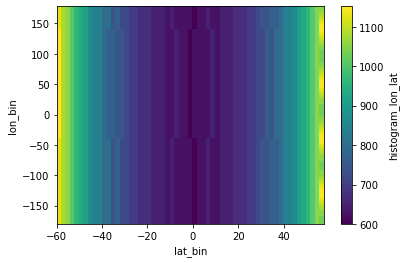

In [7]:
N.plot()

In [8]:
ds_binned = xr.concat([(histogram(ds.lon.rename('lon'), ds.lat.rename('lat'),bins=[lon_bins, lat_bins], weights=ds.correlation.isel(lags=i).fillna(0.),
                  dim=['i', 'j', 'face']
                 )/(N/2)).rename('rr') for i in range(ds.lags.size)], dim='lags')

AttributeError: 'Dataset' object has no attribute 'correlation'

In [8]:
ds_binned = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'),
                      bins=[lon_bins, lat_bins],
                      weights=ds.Crr.fillna(0.),dim=['i', 'j', 'face']).persist()
ds_binned = (ds_binned/N).rename('rr').assign_coords({'lags':ds_binned.lags}).persist()
ds_binned

<xarray.DataArray 'rr' (lags: 321, lon_bin: 179, lat_bin: 59)>
dask.array<truediv, shape=(321, 179, 59), dtype=float64, chunksize=(321, 179, 59), chunktype=numpy.ndarray>
Coordinates:
  * lon_bin  (lon_bin) float64 -179.0 -177.0 -175.0 -173.0 ... 173.0 175.0 177.0
  * lat_bin  (lat_bin) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lags     (lags) int64 0 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320

In [13]:
ds_binned.mean('lags').plot(y='lat_bin')

KeyboardInterrupt: 

In [9]:
ds_binned_ii = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'),
                      bins=[lon_bins, lat_bins],
                      weights=ds.Cii.fillna(0.),dim=['i', 'j', 'face']).persist()
ds_binned_ii = (ds_binned_ii/N).rename('ii').assign_coords({'lags':ds_binned_ii.lags}).persist()
ds_binned_ii

<xarray.DataArray 'ii' (lags: 321, lon_bin: 179, lat_bin: 59)>
dask.array<truediv, shape=(321, 179, 59), dtype=float64, chunksize=(321, 179, 59), chunktype=numpy.ndarray>
Coordinates:
  * lon_bin  (lon_bin) float64 -179.0 -177.0 -175.0 -173.0 ... 173.0 175.0 177.0
  * lat_bin  (lat_bin) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lags     (lags) int64 0 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320

In [10]:
_ds_binned = histogram(ds.lon.rename('lon'), ds.lat.rename('lat'),
                      bins=[lon_bins, lat_bins],
                      weights=ds.Cri.fillna(0.),dim=['i', 'j', 'face']).persist()
_ds_binned = (_ds_binned/N).rename('ri').assign_coords({'lags':ds_binned.lags}).persist()

In [11]:
_ds_binned = (_ds_binned).rename('ri').persist()

In [12]:
ds_out = xr.merge([ds_binned,ds_binned_ii,_ds_binned,N.rename('count')])
#ds_out = ds_binned
ds_out = ds_out.assign_coords({'lags':ds.lags})

In [13]:
ds_out

<xarray.Dataset>
Dimensions:  (lon_bin: 179, lat_bin: 59, lags: 321)
Coordinates:
  * lon_bin  (lon_bin) float64 -179.0 -177.0 -175.0 -173.0 ... 173.0 175.0 177.0
  * lat_bin  (lat_bin) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lags     (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
Data variables:
    rr       (lags, lon_bin, lat_bin) float64 dask.array<chunksize=(321, 179, 59), meta=np.ndarray>
    ii       (lags, lon_bin, lat_bin) float64 dask.array<chunksize=(321, 179, 59), meta=np.ndarray>
    ri       (lags, lon_bin, lat_bin) float64 dask.array<chunksize=(321, 179, 59), meta=np.ndarray>
    count    (lon_bin, lat_bin) int64 dask.array<chunksize=(179, 59), meta=np.ndarray>

In [14]:
ds_out = ds_out.rename({'lat_bin':'lat_bins','lon_bin':'lon_bins'})

In [15]:
ds_out = ds_out.persist()

In [16]:
ds_out.attrs.update({'binsize':dl})

In [17]:
ds_out = ds_out.compute()

ds_out

<xarray.Dataset>
Dimensions:   (lon_bins: 179, lat_bins: 59, lags: 321)
Coordinates:
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bins  (lat_bins) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
  * lags      (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
Data variables:
    rr        (lags, lon_bins, lat_bins) float64 0.0008438 ... -0.003784
    ii        (lags, lon_bins, lat_bins) float64 0.0009194 ... -0.003122
    ri        (lags, lon_bins, lat_bins) float64 9.178e-05 0.000117 ... 0.002581
    count     (lon_bins, lat_bins) int64 1128 1080 1056 1008 ... 1008 1056 1056
Attributes:
    binsize:  2.0

In [18]:
_ = ds_out.to_netcdf(path='/home1/datawork/zcaspar/mit4320/Ecov_SSU_dl2.nc')

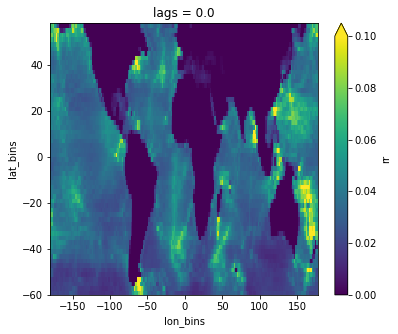

In [27]:
fig,ax = plt.subplots(figsize=(6,5))
np.sqrt(ds_out.isel(lags=0).rr).plot(vmax=0.1,y='lat_bins',ax=ax)

In [21]:
#client.restart()
#
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
